## Which neiborhood in Chicago would I like the most? ;)


In [1]:
import pandas as pd
import numpy as np
import math
import json
import requests
from geopy.geocoders import Nominatim
from pandas import json_normalize  
import folium
import wget
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
    #from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
    #from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans


In [2]:
#--set up parameters for call

client_id = "042PAXPIJP1BTANAVAMVMPAX55ABB520NRDH1OXR3MDK5P2Q"
client_srt = "STE5MQZGMNGCVYWLBX22V5CZAJU2ZVM2HSOX1TCZYHCR1HRI"
version = "20200602"
limit = 100
radius = 10000 #--10km, about 6 mi
#lat = None
#lng = None


#--just set the location to Chicago
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode("Chicago, IL")
print(location)
loc_lat = location.latitude
loc_lng = location.longitude
print(loc_lat, loc_lng)

Chicago, Cook County, Illinois, United States of America
41.8755616 -87.6244212


## Section 1: Gathering, and Processing of Raw Data

#### Data include:
<li>Chicago geo data: ward(neighborhood) and it's coordinate </li> 
<li>CTA public transportation: CTA L Trains stops, station name and coordinate</li> 
<li>Divvy: Chicago bike share, station coordinate</li>
<li>Crime: City Crima record, crime type and coordinate</li>
<li>foursquare dataset: split venue into retail(including goods and service) and enviroment(including public recreational area) </li>




In [3]:
#--get json ward data, normalize it, and reformat coordinates.  because crime data has ward, so use ward

#chicago_boundray = requests.get("https://data.cityofchicago.org/resource/y6yq-dbs2.json").json()

chicago_ward = requests.get("https://data.cityofchicago.org/resource/k9yb-bpqx.json").json()


chicago_geo = json_normalize(chicago_ward)#.drop(["the_geom.type"], axis = 1)

chicago_geo["lat"] = [chicago_geo["the_geom.coordinates"][ind][0][0][0][1] for ind in np.arange(0,len(chicago_geo))]
chicago_geo["lng"] = [chicago_geo["the_geom.coordinates"][ind][0][0][0][0] for ind in np.arange(0,len(chicago_geo))]


print(chicago_geo.loc[[2], ["lat","lng"]],chicago_geo["the_geom.coordinates"][2][0][0][0])
#--looks like just rounded 
chicago_geo["ward"]=chicago_geo["ward"].astype("int")
chicago_geo.drop(["the_geom.coordinates","the_geom.type"], axis = 1, inplace = True)
chicago_geo = chicago_geo.sort_values(by = "ward", ascending = True).reset_index(drop = True)
chicago_geo["ward"].unique() #--50
chicago_geo.head()

         lat        lng
2  41.817294 -87.698175 [-87.69817510963803, 41.81729440755995]


,ward,shape_leng,shape_area,lat,lng
0,1,102569.70148,69757593.8542,41.928632,-87.678178
1,2,110739.852187,53934808.8716,41.927232,-87.661367
2,3,81530.2751668,123341548.953,41.855424,-87.618215
3,4,119468.403755,126006901.096,41.873357,-87.625971
4,5,102271.665896,115196005.523,41.805851,-87.583365


In [4]:
#--get CTA L train stops 

chicago_cta = pd.read_json("https://data.cityofchicago.org/resource/zbnc-zirh.json")[["station_name","location"]]



chicago_cta["lat"] = [chicago_cta["location"][loc]["latitude"] for loc in (np.arange(0, len(chicago_cta)))]
chicago_cta["lng"] = [chicago_cta["location"][loc]["longitude"] for loc in (np.arange(0, len(chicago_cta)))]


chicago_cta_stops = chicago_cta[["station_name","lat","lng"]].drop_duplicates(ignore_index = True)
chicago_cta_stops[["lat"]] = chicago_cta_stops[["lat"]].astype(float)
chicago_cta_stops[["lng"]] = chicago_cta_stops[["lng"]].astype(float)
#chicago_cta_stops.dtypes
chicago_cta_stops.head()


,station_name,lat,lng
0,18th,41.857908,-87.669147
1,35th/Archer,41.829353,-87.680622
2,35th-Bronzeville-IIT,41.831677,-87.625826
3,43rd,41.816462,-87.619021
4,47th,41.809209,-87.618826


In [5]:
#--define how to calculate distance 


def distance(lat1, lon1,  lat2, lon2):
    radius = 6371  #--km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2)*math.sin(dlat/2)+math.cos(math.radians(lat1))*math.cos(math.radians(lat2))*math.sin(dlon/2)*math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c
    return d


In [6]:
#--calculate how many L train stops around each ward are within walking distance, and append to chicago_geo

walking_dist = 2
cols = ["ward", "stops","dist"]
dist_list = []
    
for row in np.arange(0,len(chicago_geo)):
    lat1 = chicago_geo["lat"][row]
    lng1 = chicago_geo["lng"][row]
    ward = chicago_geo["ward"][row]              
    for row_cta in np.arange(0,len(chicago_cta_stops)):
        lat2 = chicago_cta_stops["lat"][row_cta]
        lng2 = chicago_cta_stops["lng"][row_cta]
        stops = chicago_cta_stops["station_name"][row_cta]   
        dist = distance(lat1, lng1,  lat2, lng2)
        dist_list.append((ward, stops, dist))
    dist_df = pd.DataFrame(dist_list, columns = cols)
    dist_cnt = dist_df[dist_df["dist"] < walking_dist]
    dist_cnt = dist_cnt[["ward","stops"]].groupby("ward").count().reset_index().sort_values(by = "ward") 
chicago_geo_cta = pd.merge(chicago_geo, dist_cnt, on = "ward", how = "left").fillna(0)
  

chicago_geo_cta.head()

,ward,shape_leng,shape_area,lat,lng,stops
0,1,102569.70148,69757593.8542,41.928632,-87.678178,3.0
1,2,110739.852187,53934808.8716,41.927232,-87.661367,7.0
2,3,81530.2751668,123341548.953,41.855424,-87.618215,4.0
3,4,119468.403755,126006901.096,41.873357,-87.625971,22.0
4,5,102271.665896,115196005.523,41.805851,-87.583365,0.0


In [7]:
#--get divvy bike station!

chicago_divvy = pd.read_json("https://data.cityofchicago.org/resource/bk89-9dk7.json")[["station_name","latitude","longitude"]]


chicago_divvy[["latitude"]] = chicago_divvy[["latitude"]].astype(float)
chicago_divvy[["longitude"]] = chicago_divvy[["longitude"]].astype(float)
chicago_divvy.dtypes
chicago_divvy.head()


,station_name,latitude,longitude
0,Dorchester Ave & 63rd St,41.780406,-87.591416
1,Ellis Ave & 53rd St,41.799336,-87.600958
2,Shedd Aquarium,41.867226,-87.615355
3,Kimbark Ave & 53rd St,41.799568,-87.594747
4,Broadway & Barry Ave,41.937582,-87.644098


In [8]:
#--calculate how many divvy stations around each ward are within walking distance, and append to chicago_geo

walking_dist = 2
cols = ["ward", "stastion","dist"]
dist_list2 = []
    
for row in np.arange(0,len(chicago_geo)):
    lat1 = chicago_geo["lat"][row]
    lng1 = chicago_geo["lng"][row]
    ward = chicago_geo["ward"][row]              
    for row_divvy in np.arange(0,len(chicago_divvy)):
        lat2 = chicago_divvy["latitude"][row_divvy]
        lng2 = chicago_divvy["longitude"][row_divvy]
        station = chicago_divvy["station_name"][row_divvy]   
        dist = distance(lat1, lng1,  lat2, lng2)
        dist_list2.append((ward, station, dist))
    dist_df = pd.DataFrame(dist_list2, columns = cols)
    dist_cnt = dist_df[dist_df["dist"] < walking_dist]
    dist_cnt = dist_cnt[["ward","stastion"]].groupby("ward").count().reset_index().sort_values(by = "ward") 
    chicago_geo_cta_divvy = pd.merge(chicago_geo_cta, dist_cnt, on = "ward", how = "left").fillna(0)

chicago_geo_cta_divvy.head()

,ward,shape_leng,shape_area,lat,lng,stops,stastion
0,1,102569.70148,69757593.8542,41.928632,-87.678178,3.0,36.0
1,2,110739.852187,53934808.8716,41.927232,-87.661367,7.0,49.0
2,3,81530.2751668,123341548.953,41.855424,-87.618215,4.0,26.0
3,4,119468.403755,126006901.096,41.873357,-87.625971,22.0,76.0
4,5,102271.665896,115196005.523,41.805851,-87.583365,0.0,16.0


In [9]:
#--get crime rate data 

chicago_crime = pd.read_json("https://data.cityofchicago.org/resource/dfnk-7re6.json")
#print(chicago_crime["date_of_occurrence"].min(), chicago_crime["date_of_occurrence"].max())
#--this is crime rate from 2019-06-01 to 2020-04-27

chicago_crime = chicago_crime[["ward","date_of_occurrence","_primary_decsription","latitude","longitude","_location_description"]].sort_values(by = "ward")

chicago_crime.head()

,ward,date_of_occurrence,_primary_decsription,latitude,longitude,_location_description
684,1,2019-09-05T00:51:00.000,DECEPTIVE PRACTICE,41.929633,-87.678777,STREET
606,1,2019-11-03T20:40:00.000,THEFT,41.929744,-87.684274,DEPARTMENT STORE
952,1,2019-11-03T20:13:00.000,NARCOTICS,41.914877,-87.699227,STREET
595,1,2019-09-05T20:00:00.000,THEFT,41.910117,-87.677445,CTA TRAIN
24,1,2020-04-27T17:45:00.000,THEFT,41.895896,-87.677913,GROCERY FOOD STORE


In [10]:
#---group by for the ward, then add a total for crime 

ch_crime_group = chicago_crime[["ward","date_of_occurrence","_primary_decsription"]].groupby(["ward","_primary_decsription"], as_index = False).count()

ch_crime_group.rename(columns = {"_primary_decsription":"primary_decsription","date_of_occurrence":"cnt"}, inplace = True)
ch_crime_ward = ch_crime_group.pivot(index="ward", columns = "primary_decsription").fillna(0)

ch_crime_ward.columns = [ch_crime_ward.columns[col][-1] for col in np.arange(0, len(ch_crime_ward.columns))] 
ch_crime_ward["Total"] = ch_crime_ward.sum(axis = 1)

ch_crime_ward.head()

,ARSON,ASSAULT,BATTERY,BURGLARY,CONCEALED CARRY LICENSE VIOLATION,CRIM SEXUAL ASSAULT,CRIMINAL DAMAGE,CRIMINAL SEXUAL ASSAULT,CRIMINAL TRESPASS,DECEPTIVE PRACTICE,...,OFFENSE INVOLVING CHILDREN,OTHER OFFENSE,PROSTITUTION,PUBLIC PEACE VIOLATION,ROBBERY,SEX OFFENSE,STALKING,THEFT,WEAPONS VIOLATION,Total
ward,,,,,,,,,,,,,,,,,,,,,
1,0.0,2.0,2.0,0.0,0.0,0.0,4.0,0.0,2.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,28.0
2,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,22.0
3,0.0,3.0,5.0,2.0,0.0,0.0,5.0,0.0,1.0,1.0,...,1.0,2.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,26.0
4,0.0,1.0,4.0,0.0,0.0,0.0,9.0,0.0,1.0,4.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,12.0,0.0,34.0
5,0.0,1.0,5.0,0.0,0.0,0.0,7.0,0.0,1.0,0.0,...,0.0,3.0,0.0,0.0,1.0,0.0,0.0,5.0,0.0,25.0


In [11]:
#--append the total and relevant crime to chicago geo data

chicago_geo_tot = pd.merge(chicago_geo_cta_divvy, ch_crime_ward[["ROBBERY","BURGLARY","THEFT","Total"]], on = "ward", how = "left")

chicago_geo_tot.rename(columns = {"stops":"LTrain_Stop_cnt", "stastion":"Divvy_Station_cnt", "ROBBERY":"C_Robbery_cnt", 
                        "BURGLARY":"C_Burglary_cnt", "THEFT":"C_Theft_cnt", "Total":"C_Total_cnt"}, inplace = True)

chicago_geo_tot.head()

,ward,shape_leng,shape_area,lat,lng,LTrain_Stop_cnt,Divvy_Station_cnt,C_Robbery_cnt,C_Burglary_cnt,C_Theft_cnt,C_Total_cnt
0,1,102569.70148,69757593.8542,41.928632,-87.678178,3.0,36.0,0.0,0.0,13.0,28.0
1,2,110739.852187,53934808.8716,41.927232,-87.661367,7.0,49.0,0.0,0.0,13.0,22.0
2,3,81530.2751668,123341548.953,41.855424,-87.618215,4.0,26.0,0.0,2.0,4.0,26.0
3,4,119468.403755,126006901.096,41.873357,-87.625971,22.0,76.0,1.0,0.0,12.0,34.0
4,5,102271.665896,115196005.523,41.805851,-87.583365,0.0,16.0,1.0,0.0,5.0,25.0


In [12]:
#--get foursquare data

#--create a function for explore area of a given neighborhood  

explore_area = None

def explore_area(names, latitudes, longitudes, radius = radius):    #--this is just the name for neighborhood/borough
    
    venue_lis = []
    for name, lat, lng in zip(names, latitudes, longitudes):
    
        url="https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}".format(client_id, client_srt, lat, lng, version, radius, limit)
    
        venue = requests.get(url).json()["response"]["groups"][0]["items"]
        
        venue_lis.append([(name, lat, lng,
                       v["venue"]["name"],    
                       v["venue"]["categories"][0]["name"],    
                       v["venue"]["location"]["lat"],
                       v["venue"]["location"]["lng"]) for v in venue])
    
    df_venue = pd.DataFrame([item for venue_lis in venue_lis for item in venue_lis])
    df_venue.columns = ["neighborhood", "neighborhood_lat", "neighborhood_lng",
                        "venue", "categories", "venue_lat","venue_lng"] 
   
    return(df_venue)

In [13]:
#--apply the function to list of Chicago wards:

chicago_venue = explore_area(chicago_geo_tot["ward"],chicago_geo_tot["lat"],chicago_geo_tot["lng"])
chicago_venue.sort_values(by = "neighborhood", ascending = True, inplace = True)


chicago_venue.reset_index(drop = True, inplace = True)

chicago_venue.head()

,neighborhood,neighborhood_lat,neighborhood_lng,venue,categories,venue_lat,venue_lng
0,1,41.928632,-87.678178,Forever Yogurt,Frozen Yogurt Shop,41.931247,-87.686127
1,1,41.928632,-87.678178,Boka,New American Restaurant,41.913629,-87.648196
2,1,41.928632,-87.678178,Intelligentsia Coffee,Coffee Shop,41.938226,-87.644381
3,1,41.928632,-87.678178,Damn Fine Coffee Bar,Coffee Shop,41.917335,-87.711004
4,1,41.928632,-87.678178,Crisp,Fried Chicken Joint,41.936055,-87.644292


In [14]:
#--export the categories to csv for a better look at all: 
chicago_venue.categories.to_csv("categories.csv", index = False)

#csv_path = "C:\Users\Yiwen\Python\Data\categories_edit.csv"

df_category = pd.read_csv("categories_edit.csv", encoding = "unicode_escape")

df_category.head(20)

,category,category_edit,category_cafe
0,African Restaurant,NaN,NaN
1,American Restaurant,NaN,NaN
2,Amphitheater,category_env,NaN
3,Aquarium,category_env,NaN
4,Art Gallery,category_env,NaN
5,Art Museum,category_env,NaN
6,Arts & Crafts Store,NaN,NaN
7,Asian Restaurant,NaN,NaN
8,Automotive Shop,NaN,NaN
9,Bagel Shop,NaN,NaN


In [15]:

#--enviroment related categories
category_env = df_category["category"][df_category["category_edit"] == "category_env"].tolist()

#--not relevant categories 
category_dnu = df_category["category"][df_category["category_edit"] == "category_dnu"].tolist()



retail_list = []
for row in np.arange(0,len(chicago_venue)):
    if chicago_venue["categories"][row] not in category_env + category_dnu: 
        retail_list.append(chicago_venue.loc[row,:])
        retail_df = pd.DataFrame(retail_list)

retail_df.head()

,neighborhood,neighborhood_lat,neighborhood_lng,venue,categories,venue_lat,venue_lng
0,1,41.928632,-87.678178,Forever Yogurt,Frozen Yogurt Shop,41.931247,-87.686127
1,1,41.928632,-87.678178,Boka,New American Restaurant,41.913629,-87.648196
2,1,41.928632,-87.678178,Intelligentsia Coffee,Coffee Shop,41.938226,-87.644381
3,1,41.928632,-87.678178,Damn Fine Coffee Bar,Coffee Shop,41.917335,-87.711004
4,1,41.928632,-87.678178,Crisp,Fried Chicken Joint,41.936055,-87.644292


In [16]:
#--venue by category within each neighborhood, use only retail categories to calculate frequency!

chicago_retail_summary = pd.concat([retail_df[["neighborhood"]], pd.get_dummies(retail_df[["categories"]])], axis = 1)


#--change column names 
col_list = []
for i in np.arange(1, len(chicago_retail_summary.columns)):
    col_list.append(chicago_retail_summary.columns[i].split("_")[-1])
col_list.insert(0,"neighborhood")
chicago_retail_summary.columns = col_list


#--get the pct of type of venue in the neighborhood.
chicago_retail_freq = chicago_retail_summary.groupby("neighborhood").mean().reset_index().sort_values(by = "neighborhood")  

#--because ward 10 has nothing so merge it 
chicago_retail_freq = pd.merge(chicago_geo_tot[["ward"]], chicago_retail_freq, left_on = "ward"
                               , right_on= "neighborhood", how = "left").fillna(0).drop("ward", axis = 1)
chicago_retail_freq["neighborhood"] = chicago_retail_freq["neighborhood"].astype(int)
chicago_retail_freq.head()

,neighborhood,African Restaurant,American Restaurant,Arts & Crafts Store,Asian Restaurant,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bar,...,Tour Provider,Toy / Game Store,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,1,0.000000,0.011111,0.000000,0.011111,0.0,0.000000,0.0,0.011111,0.011111,...,0.000000,0.000000,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.011111
1,2,0.000000,0.011494,0.000000,0.011494,0.0,0.000000,0.0,0.011494,0.000000,...,0.000000,0.000000,0.034483,0.0,0.0,0.0,0.0,0.0,0.0,0.011494
2,3,0.013699,0.000000,0.000000,0.000000,0.0,0.013699,0.0,0.000000,0.013699,...,0.027397,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.027397
3,4,0.000000,0.000000,0.000000,0.000000,0.0,0.014085,0.0,0.014085,0.000000,...,0.028169,0.014085,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.028169
4,5,0.017241,0.000000,0.017241,0.000000,0.0,0.000000,0.0,0.000000,0.017241,...,0.034483,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.017241


In [17]:
#--get top by frequency, retail only!

#--just do a quick test to see there is data 
chicago_retail_freq[chicago_retail_freq["neighborhood"] == 2].T.reset_index()[1:].sort_values(by = 1, ascending = False)
#chicago_retail_freq[chicago_retail_freq["neighborhood"] == 27].T.reset_index()[26:].sort_values(by = 26, ascending = False)


#--functions:

def most_common (row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


def top_venue(top):
    columns = ["neighborhood"]

    for ind in np.arange(top):
        columns.append("Top{}_Venue".format(ind+1))
        
    df = pd.DataFrame(columns = columns)
    df["neighborhood"] = chicago_retail_freq["neighborhood"]
    
    for ind in np.arange(chicago_retail_freq.shape[0]):
        df.iloc[ind,1:] = most_common(chicago_retail_freq.iloc[ind, :], top) 
        
    return(df)

top_venue_tot = top_venue(3)
top_venue_tot.head()



,neighborhood,Top1_Venue,Top2_Venue,Top3_Venue
0,1,Coffee Shop,Ice Cream Shop,Brewery
1,2,Coffee Shop,Ice Cream Shop,Brewery
2,3,Hotel,Grocery Store,Coffee Shop
3,4,Hotel,Grocery Store,Sandwich Place
4,5,Grocery Store,Hotel,Coffee Shop


In [18]:
#--get venue count by category, by neighborhood

temp = chicago_venue[["neighborhood","categories"]].reset_index()

temp2 = temp.groupby(["neighborhood","categories"]).count().reset_index()
temp2.sum("index")

temp3 = temp2.pivot(index = "neighborhood", columns = "categories").fillna(0)


#--change column names 
col_list = []
for i in np.arange(0, len(temp3.columns)):
    col_list.append(temp3.columns[i][-1])
#col_list.insert(0,"neighborhood")
temp3.columns = col_list

chicago_venue_cnt = temp3.reset_index()

#--ward 10 has nothing so merge it 
chicago_venue_cnt = pd.merge(chicago_geo_tot[["ward"]], chicago_venue_cnt, left_on = "ward"
                               , right_on= "neighborhood", how = "left").fillna(0).drop("ward", axis = 1)

chicago_venue_cnt.head()


,neighborhood,African Restaurant,American Restaurant,Amphitheater,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Automotive Shop,...,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo
0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
2,3,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0
3,4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0
4,5,1.0,0.0,1.0,1.0,2.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0


In [44]:
#--get the relevent venue type and group them into groups, caculate count, and freq, then add everything to main dataset
col_venue_group = ["V_Cafe", "V_books", "V_Sweets"]

category_sweets = df_category["category"][df_category["category_cafe"] == "sweets"].tolist()


venue_cnt = pd.DataFrame()

venue_cnt["V_Cafe"] = chicago_venue_cnt[["Café","Coffee Shop"]].sum(axis = 1)  #--or venue_cnt["Café"] + venue_cnt["Coffee Shop"]
venue_cnt["V_books"]= chicago_venue_cnt[["Bookstore"]].sum(axis = 1)
venue_cnt["V_Sweets"]= chicago_venue_cnt[category_sweets].sum(axis = 1)
venue_cnt["V_Pub_Rec_Area"]= chicago_venue_cnt[category_env].sum(axis = 1)
#venue_cnt["V_Coworking Space"]= chicago_venue_cnt[category_cowork].sum(axis = 1)



venue_freq = pd.DataFrame()
venue_freq["V_Cafe"] = chicago_retail_freq[["Café","Coffee Shop"]].sum(axis = 1) 
venue_freq["V_books"]= chicago_venue_cnt[["Bookstore"]].sum(axis = 1)
venue_freq["V_Sweets"]= chicago_retail_freq[category_sweets].sum(axis = 1)

temp1 = venue_cnt.add_suffix('_cnt')
temp2 = venue_freq.add_suffix('_freq')


chicago_data = pd.concat([chicago_geo_tot,temp1, temp2, top_venue_tot[["Top1_Venue","Top2_Venue","Top3_Venue"]]], axis = 1)
chicago_data.drop(["shape_leng","shape_area"], axis = 1, inplace = True)


#--this is the main dataset!!!!!!!!!!!!!!!!!!!!!!!!
chicago_data.head()

,ward,lat,lng,LTrain_Stop_cnt,Divvy_Station_cnt,C_Robbery_cnt,C_Burglary_cnt,C_Theft_cnt,C_Total_cnt,V_Cafe_cnt,V_books_cnt,V_Sweets_cnt,V_Pub_Rec_Area_cnt,V_Cafe_freq,V_books_freq,V_Sweets_freq,Top1_Venue,Top2_Venue,Top3_Venue
0,1,41.928632,-87.678178,3.0,36.0,0.0,0.0,13.0,28.0,13.0,1.0,10.0,10.0,0.144444,1.0,0.111111,Coffee Shop,Ice Cream Shop,Brewery
1,2,41.927232,-87.661367,7.0,49.0,0.0,0.0,13.0,22.0,12.0,1.0,9.0,13.0,0.137931,1.0,0.103448,Coffee Shop,Ice Cream Shop,Brewery
2,3,41.855424,-87.618215,4.0,26.0,0.0,2.0,4.0,26.0,6.0,1.0,4.0,23.0,0.082192,1.0,0.054795,Hotel,Grocery Store,Coffee Shop
3,4,41.873357,-87.625971,22.0,76.0,1.0,0.0,12.0,34.0,5.0,1.0,4.0,25.0,0.070423,1.0,0.056338,Hotel,Grocery Store,Sandwich Place
4,5,41.805851,-87.583365,0.0,16.0,1.0,0.0,5.0,25.0,7.0,0.0,3.0,37.0,0.120690,0.0,0.051724,Grocery Store,Hotel,Coffee Shop


## Section 2: Analisis



In [45]:
#--normalize whole dataset and add ward as index

array_ch = chicago_data.set_index("ward").values[:,2:15]       #--all rows, columns start from 3 (from LTrain_Stop_cnt to V_Snack_freq)
array_ch = np.nan_to_num(array_ch)    #--change nan to num, it is an array here now!!!!!
array_normal = StandardScaler().fit_transform(array_ch)
chicago_data_normal= pd.DataFrame(array_normal, columns= chicago_data.columns[3:16])
chicago_data_normal = pd.concat([chicago_data[["ward"]], chicago_data_normal] , axis = 1).set_index("ward")

chicago_data_normal.head()


,LTrain_Stop_cnt,Divvy_Station_cnt,C_Robbery_cnt,C_Burglary_cnt,C_Theft_cnt,C_Total_cnt,V_Cafe_cnt,V_books_cnt,V_Sweets_cnt,V_Pub_Rec_Area_cnt,V_Cafe_freq,V_books_freq,V_Sweets_freq
ward,,,,,,,,,,,,,
1,-0.208013,0.812780,-0.661110,-0.825029,1.810004,0.667781,1.903162,0.257209,0.880812,-0.731858,1.706500,0.257209,0.771150
2,0.485363,1.423540,-0.661110,-0.825029,1.810004,0.166945,1.579495,0.257209,0.501152,-0.285603,1.520094,0.257209,0.490465
3,-0.034669,0.342965,-0.661110,1.466718,-0.252026,0.500835,-0.362507,0.257209,-1.397151,1.201913,-0.075097,0.257209,-1.291695
4,3.085520,2.692040,0.912961,-0.825029,1.580890,1.168616,-0.686174,0.257209,-1.397151,1.499416,-0.411919,0.257209,-1.235157
5,-0.728044,-0.126850,0.912961,-0.825029,-0.022911,0.417363,-0.038840,-0.911922,-1.776811,3.284434,1.026666,-0.911922,-1.404161


In [46]:
#--check is number of cafe is correlated with any other measurement 

chicago_data_normal.corr()
chicago_data_normal.corr()["V_Cafe_cnt"].sort_values(ascending = False)

V_Cafe_cnt            1.000000
V_Cafe_freq           0.971597
V_Sweets_cnt          0.095653
Divvy_Station_cnt     0.086007
V_Sweets_freq         0.058618
LTrain_Stop_cnt      -0.013690
C_Burglary_cnt       -0.046879
C_Theft_cnt          -0.055766
C_Total_cnt          -0.059438
C_Robbery_cnt        -0.127573
V_Pub_Rec_Area_cnt   -0.130495
V_books_freq         -0.164078
V_books_cnt          -0.164078
Name: V_Cafe_cnt, dtype: float64

In [47]:
#--Would cafe count have a correlation with park only? 
temp_park = np.nan_to_num(pd.concat([chicago_data[["V_Cafe_cnt"]],chicago_venue_cnt[["neighborhood","Park"]]], axis = 1).set_index("neighborhood").values[:])
temp_park_df = pd.concat([chicago_venue_cnt[["neighborhood"]],pd.DataFrame(StandardScaler().fit_transform(temp_park), columns = ["V_Cafe_cnt","Park"])], axis = 1).set_index("neighborhood")


temp_park_df.corr()
#--nope

,V_Cafe_cnt,Park
V_Cafe_cnt,1.000000,-0.180471
Park,-0.180471,1.000000


In [48]:
#--describe 

print(chicago_data[["V_Cafe_cnt"]].describe(), chicago_data[["V_books_cnt"]].describe())

       V_Cafe_cnt
count   50.000000
mean     7.120000
std      3.120963
min      2.000000
25%      5.000000
50%      7.000000
75%      9.750000
max     13.000000        V_books_cnt
count     50.00000
mean       0.78000
std        0.86402
min        0.00000
25%        0.00000
50%        1.00000
75%        1.00000
max        3.00000


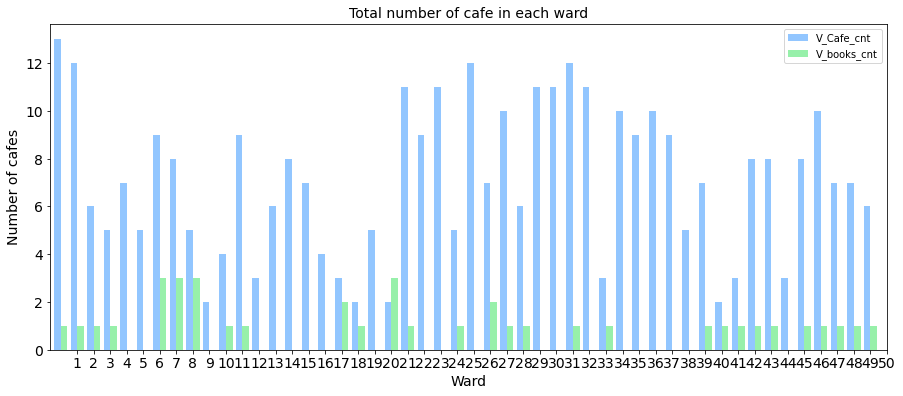

In [49]:
#--plot
mpl.style.use(["seaborn-pastel"])

chicago_data[["ward","V_Cafe_cnt","V_books_cnt"]].set_index("ward").plot(kind = "bar", figsize=(15,6), width = 0.8, fontsize = 14)
plt.title("Total number of cafe in each ward", fontsize = 14)
plt.xlabel("Ward", fontsize = 14)
plt.ylabel("Number of cafes", fontsize = 14)
plt.xticks(chicago_data.ward, rotation= 0)

plt.show()
plt.close()

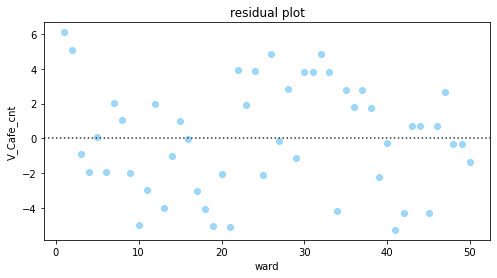

In [43]:
#--resplot 

plt.figure(figsize = (8,4))
sns.residplot(chicago_data["ward"], chicago_data["V_Cafe_cnt"], color = "lightskyblue")
plt.title("residual plot")
plt.show()

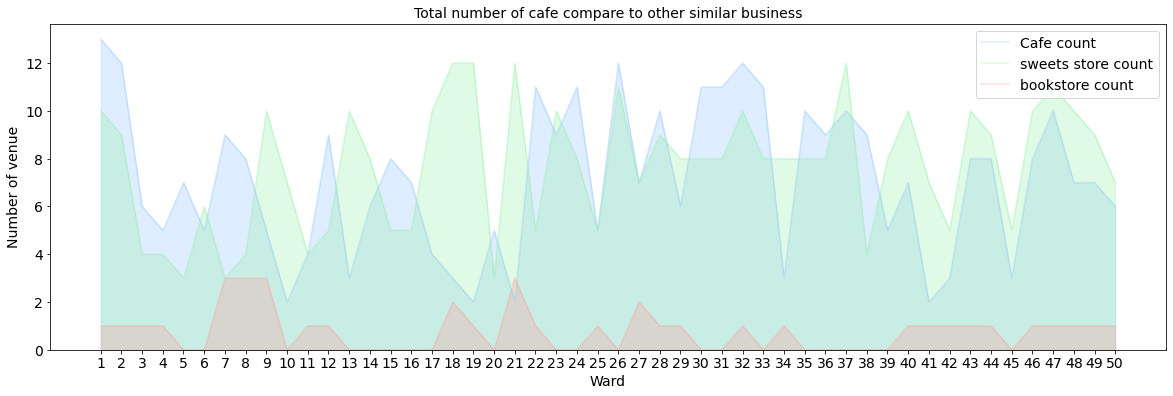

In [51]:
#--area plot

chicago_data[["ward","V_Cafe_cnt","V_Sweets_cnt","V_books_cnt"]].set_index("ward").plot(kind = "area", 
                                                                                              alpha = 0.3, 
                                                                                              stacked = False, 
                                                                                              figsize = (20,6),
                                                                                              fontsize = 14) 

plt.xlabel("Ward", fontsize = 14)
plt.ylabel("Number of venue", fontsize = 14)
plt.title("Total number of cafe compare to other similar business", fontsize = 14)
plt.legend(labels = ["Cafe count","sweets store count","bookstore count"],fontsize = 14)
plt.xticks(chicago_data.ward)
plt.show()

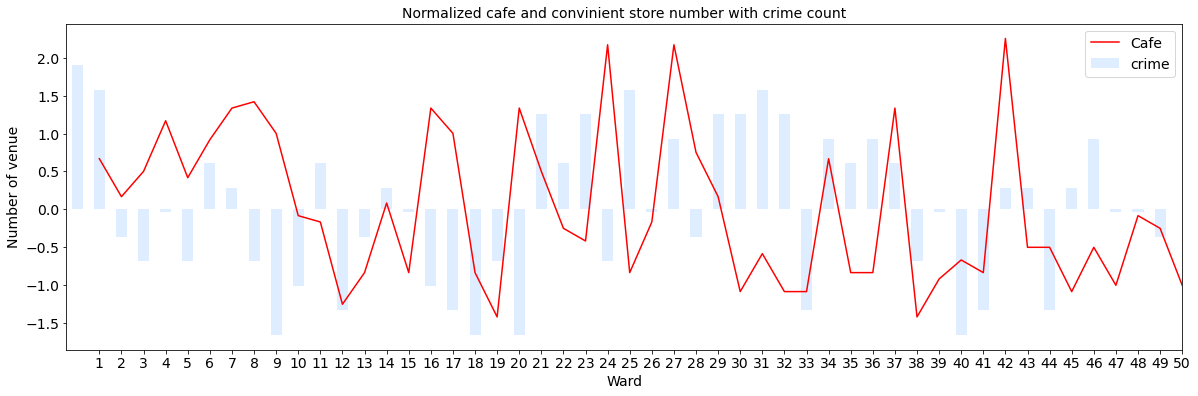

In [29]:
#--area plot adding in crime rate, after normalize the data

ax1 = chicago_data_normal[["V_Cafe_cnt"]].plot(kind = "bar", 
                                                                                              alpha = 0.3, 
                                                                                              stacked = False, 
                                                                                               figsize = (20,6),
                                                                                              fontsize = 14) 
plt.plot(chicago_data_normal[["C_Total_cnt"]], color = "red")

plt.xlabel("Ward", fontsize = 14)
plt.ylabel("Number of venue", fontsize = 14)
plt.title("Normalized cafe and convinient store number with crime count", fontsize = 14)
plt.legend(labels = ["Cafe","crime"],fontsize = 14)
plt.xticks(chicago_data.ward, rotation = 0)
plt.show()

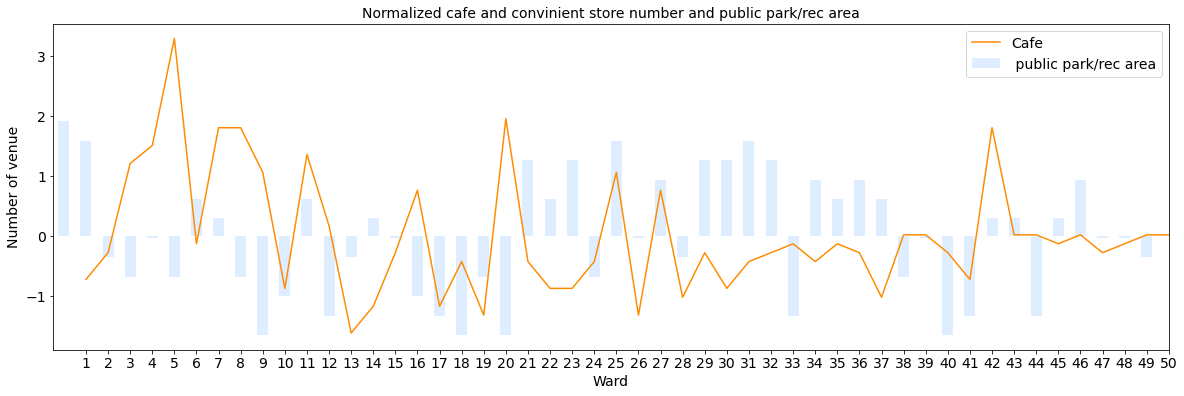

In [52]:
#--area plot adding in crime rate, after normalize the data

ax1 = chicago_data_normal[["V_Cafe_cnt"]].plot(kind = "bar", 
                                                                                              alpha = 0.3, 
                                                                                              stacked = False, 
                                                                                               figsize = (20,6),
                                                                                              fontsize = 14) 
plt.plot(chicago_data_normal[["V_Pub_Rec_Area_cnt"]], color = "darkorange")

plt.xlabel("Ward", fontsize = 14)
plt.ylabel("Number of venue", fontsize = 14)
plt.title("Normalized cafe and convinient store number and public park/rec area", fontsize = 14)
plt.legend(labels = ["Cafe"," public park/rec area"],fontsize = 14)
plt.xticks(chicago_data.ward, rotation = 0)
plt.show()

In [53]:
#--create clusters and kmean using the normalized data, but only include relevant variables

col_cafe = ["V_Cafe_cnt","Divvy_Station_cnt","LTrain_Stop_cnt","V_Sweets_cnt","V_books_cnt",
            #"V_Coworking Space_cnt",
            "V_Pub_Rec_Area_cnt","C_Total_cnt","C_Theft_cnt","C_Burglary_cnt"]
cluster_input = chicago_data_normal[col_cafe]

kclusters = 5

kmeans = KMeans(n_clusters = kclusters, random_state = 4).fit(cluster_input)
kmeans.labels_[0:5]

df_cluster = pd.DataFrame(kmeans.labels_).rename(columns = {0:"Cluster"})
df_cluster.head()

,Cluster
0,1
1,1
2,0
3,3
4,0


In [54]:
#--consolidate data back into the master dataset

chicago_data_cafe = pd.merge(chicago_data, df_cluster, left_index = True, right_index = True, how = "left")

chicago_data_cafe.head()

,ward,lat,lng,LTrain_Stop_cnt,Divvy_Station_cnt,C_Robbery_cnt,C_Burglary_cnt,C_Theft_cnt,C_Total_cnt,V_Cafe_cnt,V_books_cnt,V_Sweets_cnt,V_Pub_Rec_Area_cnt,V_Cafe_freq,V_books_freq,V_Sweets_freq,Top1_Venue,Top2_Venue,Top3_Venue,Cluster
0,1,41.928632,-87.678178,3.0,36.0,0.0,0.0,13.0,28.0,13.0,1.0,10.0,10.0,0.144444,1.0,0.111111,Coffee Shop,Ice Cream Shop,Brewery,1
1,2,41.927232,-87.661367,7.0,49.0,0.0,0.0,13.0,22.0,12.0,1.0,9.0,13.0,0.137931,1.0,0.103448,Coffee Shop,Ice Cream Shop,Brewery,1
2,3,41.855424,-87.618215,4.0,26.0,0.0,2.0,4.0,26.0,6.0,1.0,4.0,23.0,0.082192,1.0,0.054795,Hotel,Grocery Store,Coffee Shop,0
3,4,41.873357,-87.625971,22.0,76.0,1.0,0.0,12.0,34.0,5.0,1.0,4.0,25.0,0.070423,1.0,0.056338,Hotel,Grocery Store,Sandwich Place,3
4,5,41.805851,-87.583365,0.0,16.0,1.0,0.0,5.0,25.0,7.0,0.0,3.0,37.0,0.120690,0.0,0.051724,Grocery Store,Hotel,Coffee Shop,0


In [55]:
#--plot the clusters fitting for cafe~

#--create map
chicago_map = folium.Map(location = [loc_lat, loc_lng], zoom_start = 11)

cluster_colors = ["skyblue", "white", "plum", "coral", "mediumseagreen", "red","gold"]
  

for lat, lng, neignbor, cluster in zip(chicago_data_cafe["lat"], chicago_data_cafe["lng"], 
                                    chicago_data_cafe["ward"], chicago_data_cafe["Cluster"]):
    label = folium.Popup("Ward: {}, Cluster: {}".format(neignbor,cluster), parse_html = True)
    folium.CircleMarker(location= [lat, lng], radius = 10, popup = label, 
                       color = "black", fill_color = cluster_colors[cluster],  
                        fill = True, fill_opacity = 0.9).add_to(chicago_map)

chicago_map

In [56]:
#--take a look at the clusters

chicago_data_cafe_plot = chicago_data_cafe[["ward"] + col_cafe + ["Cluster"]]

chicago_data_cafe_plot.iloc[:,1:].groupby("Cluster").mean()


,V_Cafe_cnt,Divvy_Station_cnt,LTrain_Stop_cnt,V_Sweets_cnt,V_books_cnt,V_Pub_Rec_Area_cnt,C_Total_cnt,C_Theft_cnt,C_Burglary_cnt
Cluster,,,,,,,,,
0,6.714286,16.857143,1.285714,4.000000,1.000000,25.142857,32.428571,5.000000,1.857143
1,8.600000,48.800000,7.600000,8.000000,1.200000,17.000000,31.400000,15.200000,0.200000
2,9.533333,13.666667,3.400000,7.400000,0.333333,12.533333,11.733333,1.666667,0.266667
3,4.666667,79.666667,24.000000,4.333333,1.000000,23.666667,20.666667,7.333333,0.333333
4,5.450000,6.450000,2.000000,9.600000,0.900000,11.300000,18.900000,4.850000,0.850000


In [57]:
#--check out cluster 0

chicago_data_cafe[chicago_data_cafe["Cluster"] == 0]  
chicago_data_cafe[chicago_data_cafe["Cluster"] == 1]  
#chicago_data_cafe[chicago_data_cafe["Cluster"] == 2]
#chicago_data_cafe


,ward,lat,lng,LTrain_Stop_cnt,Divvy_Station_cnt,C_Robbery_cnt,C_Burglary_cnt,C_Theft_cnt,C_Total_cnt,V_Cafe_cnt,V_books_cnt,V_Sweets_cnt,V_Pub_Rec_Area_cnt,V_Cafe_freq,V_books_freq,V_Sweets_freq,Top1_Venue,Top2_Venue,Top3_Venue,Cluster
0,1,41.928632,-87.678178,3.0,36.0,0.0,0.0,13.0,28.0,13.0,1.0,10.0,10.0,0.144444,1.0,0.111111,Coffee Shop,Ice Cream Shop,Brewery,1
1,2,41.927232,-87.661367,7.0,49.0,0.0,0.0,13.0,22.0,12.0,1.0,9.0,13.0,0.137931,1.0,0.103448,Coffee Shop,Ice Cream Shop,Brewery,1
26,27,41.911197,-87.636664,6.0,53.0,1.0,1.0,18.0,46.0,7.0,2.0,7.0,20.0,0.090909,2.0,0.090909,Hotel,Coffee Shop,New American Restaurant,1
41,42,41.899210,-87.624127,11.0,63.0,0.0,0.0,20.0,47.0,3.0,1.0,5.0,27.0,0.043478,1.0,0.072464,Hotel,Burger Joint,New American Restaurant,1
43,44,41.951605,-87.656821,11.0,43.0,0.0,0.0,12.0,14.0,8.0,1.0,9.0,15.0,0.094118,1.0,0.105882,Brewery,Coffee Shop,Grocery Store,1


In [ ]:
#--check wards
chicago_data_cafe.sort_values(by = "V_books_cnt", ascending = False)

In [68]:
#--try the icon? 

#--create map
chicago_map_book = folium.Map(location = [loc_lat, loc_lng], zoom_start = 11)

cluster_colors = ["lightblue", "green", "lightred", "pink", "lightgreen", "red","gray"]
  

for lat, lng, neignbor, cluster in zip(chicago_data_cafe["lat"], chicago_data_cafe["lng"], 
                                    chicago_data_cafe["ward"], chicago_data_cafe["Cluster"]):
    label = folium.Popup("Ward: {}, Cluster: {}".format(neignbor,cluster), parse_html = True)
    folium.Marker(location= [lat, lng], radius = 10, popup = label, 
                    icon= folium.Icon(icon = "cloud", color = cluster_colors[cluster])).add_to(chicago_map_book)

chicago_map_book
